# Changing geometry with EnergyPlus and Python

## Setup

In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from copy import deepcopy

In [2]:
energyplus_install_dir=r'C:\Users\cvskf\EnergyPlusV9-6-0'  # change this to the local EnergyPlus install directory location

In [3]:
idf_relative_filepath=r'original_input_file\1ZoneUncontrolled.idf'
epw_relative_filepath=r'weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw'#
output_relative_directory='sim'

## Step 1: Convert .idf file to .epJSON

In [4]:
cl_st=(f'"{energyplus_install_dir}\\EnergyPlus" '
       + '--convert '  # included to create a .csv file of the results
       + f'--output-directory "{output_relative_directory}" '
       + f'--weather "{epw_relative_filepath}" '
       + f'"{idf_relative_filepath}"'
      )
print(cl_st)

"C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --convert --output-directory "sim" --weather "weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw" "original_input_file\1ZoneUncontrolled.idf"


In [5]:
result=subprocess.run(cl_st,
                      capture_output=True
                     )
print('---ARGS---\n',result.args)
print('---RETURNCODE---\n',result.returncode, '(SUCCESS)' if result.returncode==0 else '(FAIL)')
print('---STDOUT---\n',result.stdout.decode())
print('---STDERR---\n',result.stderr.decode())

---ARGS---
 "C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --convert --output-directory "sim" --weather "weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw" "original_input_file\1ZoneUncontrolled.idf"
---RETURNCODE---
 0 (SUCCESS)
---STDOUT---
 EnergyPlus Starting
EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.08.26 06:39
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Warming up {8}
Warming up {9}
Warming up {10}
Warming up {11}
Warming up {12}
Warming up {13}
Warming up {14}
Warming up {15}
Warming up {16}
Warming up {17}
Warming up {18}
Warming up {19}
Warming up {20}
Warming up {21}
Warming up {22}
Starting Simulation at 12/21 for DENVER CENTENNIAL  GOLDEN   N ANN HTG 99% CONDNS DB
Initializing New Environment Parameters
Warming up {1}
Warmi

## Step 2: Read in .epJSON file

In [6]:
with open(r'sim/1ZoneUncontrolled.epJSON') as f:
    epjson=json.load(f)
epjson

{'Building': {'Simple One Zone (Wireframe DXF)': {'loads_convergence_tolerance_value': 0.04,
   'maximum_number_of_warmup_days': 30,
   'minimum_number_of_warmup_days': 6,
   'north_axis': 0,
   'solar_distribution': 'MinimalShadowing',
   'temperature_convergence_tolerance_value': 0.004,
   'terrain': 'Suburbs'}},
 'BuildingSurface:Detailed': {'Zn001:Flr001': {'construction_name': 'FLOOR',
   'number_of_vertices': 4,
   'outside_boundary_condition': 'Adiabatic',
   'sun_exposure': 'NoSun',
   'surface_type': 'Floor',
   'vertices': [{'vertex_x_coordinate': 15.24,
     'vertex_y_coordinate': 0.0,
     'vertex_z_coordinate': 0.0},
    {'vertex_x_coordinate': 0.0,
     'vertex_y_coordinate': 0.0,
     'vertex_z_coordinate': 0.0},
    {'vertex_x_coordinate': 0.0,
     'vertex_y_coordinate': 15.24,
     'vertex_z_coordinate': 0.0},
    {'vertex_x_coordinate': 15.24,
     'vertex_y_coordinate': 15.24,
     'vertex_z_coordinate': 0.0}],
   'view_factor_to_ground': 1.0,
   'wind_exposure': 'N

## Step 3: Make changes to .epJSON file and save

Here, changes are made to the building geometry.

Specifically the 'vertex-x-coordinate' and 'vertex-y-coordinate' values are changed in the 'BuildingSurface:Detailed' objects.


In [7]:
x_changes=[0,10,20,30,40,50]  # change in %
y_changes=[0,-10,-20,-30,-40,-50]  # change in %

In [8]:
# a function which changes the coordinate values in a epJSON file.
def change_coordinate_value(epjson,coordinate_name,percentage_change):
    ""
    for obj_group,v in epjson.items():
        for obj_id,v1 in v.items():
            for vertex in v1.get('vertices',[]):
                if coordinate_name in vertex:
                    vertex[coordinate_name]=vertex[coordinate_name]*(1+percentage_change/100)

In [9]:
# creates the new epJSON files for each change in 'x_changes' and 'y_changes'
for i in range(len(x_changes)):
    print(i, end=' ')
    x_change=x_changes[i]
    y_change=y_changes[i]
    epjson_new=deepcopy(epjson)  # makes a copy
    change_coordinate_value(epjson_new,'vertex_x_coordinate',x_change)
    change_coordinate_value(epjson_new,'vertex_y_coordinate',y_change)
    with open(f'generated_input_files//1ZoneUncontrolled_x_{x_change}%_y_{y_change}%.epJSON', 'w') as f:
        json.dump(epjson_new,f,indent=4)

0 1 2 3 4 5 

## Step 4: Run EnergyPlus simulation on all generated input files

In [10]:
for i in range(len(x_changes)):
    print(i, end=' ')
    x_change=x_changes[i]
    y_change=y_changes[i]
    input_file=f'generated_input_files//1ZoneUncontrolled_x_{x_change}%_y_{y_change}%.epJSON'
    cl_st=(f'"{energyplus_install_dir}\\EnergyPlus" '
       + f'--output-prefix 1ZoneUncontrolled_x_{x_change}%_y_{y_change}%_ '
       + '--readvars '  # included to create a .csv file of the results
       + f'--output-directory output_files '
       + f'--weather "{epw_relative_filepath}" '
       + f'"{input_file}"'
      )
    print(cl_st)
    result=subprocess.run(cl_st,capture_output=True)
    print('RETURNCODE: ',result.returncode, '(SUCCESS)' if result.returncode==0 else '(FAIL)')
    print('---')

0 "C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --output-prefix 1ZoneUncontrolled_x_0%_y_0%_ --readvars --output-directory output_files --weather "weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw" "generated_input_files//1ZoneUncontrolled_x_0%_y_0%.epJSON"
RETURNCODE:  0 (SUCCESS)
---
1 "C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --output-prefix 1ZoneUncontrolled_x_10%_y_-10%_ --readvars --output-directory output_files --weather "weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw" "generated_input_files//1ZoneUncontrolled_x_10%_y_-10%.epJSON"
RETURNCODE:  0 (SUCCESS)
---
2 "C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --output-prefix 1ZoneUncontrolled_x_20%_y_-20%_ --readvars --output-directory output_files --weather "weather_file\USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw" "generated_input_files//1ZoneUncontrolled_x_20%_y_-20%.epJSON"
RETURNCODE:  0 (SUCCESS)
---
3 "C:\Users\cvskf\EnergyPlusV9-6-0\EnergyPlus" --output-prefix 1ZoneUncontrolled_x_30%_y_-30%_ --readvars 

## Step 5: Create a parser for the EnergyPlus datetime strings in the results file

In [11]:
def parse_energyplus_datetime_string(st, year=2021):
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    hour=int(st[7:9])
    minute=int(st[10:12])
    second=(st[13:15])
    if not hour==24:
        dt=pd.Timestamp(year,month,day,hour,minute)
    else:
        hour=0
        dt=pd.Timestamp(year,month,day,hour,minute)
        dt+=pd.Timedelta('1 day')
    return dt

# test of function - should output `Timestamp('2021-12-21 01:00:00')`
parse_energyplus_datetime_string(' 12/21  01:00:00')

Timestamp('2021-12-21 01:00:00')

## Step 6: Read in all EnergyPlus results file

In [12]:
x=[]
for i in range(len(x_changes)):
    print(i, end=' ')
    x_change=x_changes[i]
    y_change=y_changes[i]
    fp=f'output_files//1ZoneUncontrolled_x_{x_change}%_y_{y_change}%_out.csv'
    df_temp=pd.read_csv(fp, 
                        parse_dates=[0],
                        skiprows=(lambda x: x>0 and x<49), 
                            # skips rows 1 to 49, the design summer day and the design winter day in the results csv file.
                        date_parser=parse_energyplus_datetime_string  
                            # parses the date strings using the function defined above
                       )
    df_temp['simulation_run']=os.path.basename(fp)[:-8]
    df_temp=df_temp[list(df_temp.columns[-1:])+list(df_temp.columns[:-1])]  
        # moves the 'simulation_run' column to the first column position
    x.append(df_temp)
df=pd.concat(x)
df

0 1 2 3 4 5 

,simulation_run,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Total Sky Cover [](Hourly),Environment:Site Opaque Sky Cover [](Hourly),Environment:Site Daylight Saving Time Status [](Daily),Environment:Site Day Type Index [](Daily),ZONE ONE:Zone Total Internal Latent Gain Energy [J](Hourly),TEST 352 MINUS:Other Equipment Total Heating Energy [J](Monthly),TEST 352A:Other Equipment Total Heating Energy [J](Monthly),...,ZN001:FLR001:Surface Inside Face Temperature [C](Daily),ZN001:FLR001:Surface Outside Face Temperature [C](Daily),ZN001:FLR001:Surface Inside Face Convection Heat Transfer Coefficient [W/m2-K](Daily),ZN001:ROOF001:Surface Inside Face Temperature [C](Daily),ZN001:ROOF001:Surface Outside Face Temperature [C](Daily),ZN001:ROOF001:Surface Inside Face Convection Heat Transfer Coefficient [W/m2-K](Daily),ZN001:ROOF001:Surface Outside Face Convection Heat Transfer Coefficient [W/m2-K](Daily),ZONE ONE:Zone Mean Air Temperature [C](Hourly),ZONE ONE:Zone Air Heat Balance Surface Convection Rate [W](Hourly),ZONE ONE:Zone Air Heat Balance Air Energy Storage Rate [W](Hourly)
0,1ZoneUncontrolled_x_0%_y_0%,2021-01-01 01:00:00,7.0125,1.250,1.250,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.218501,-82.685781,-79.732304
1,1ZoneUncontrolled_x_0%_y_0%,2021-01-01 02:00:00,7.2000,3.250,3.250,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.050980,-28.125143,-38.693979
2,1ZoneUncontrolled_x_0%_y_0%,2021-01-01 03:00:00,6.8875,3.375,3.375,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.965326,-50.744085,-43.536604
3,1ZoneUncontrolled_x_0%_y_0%,2021-01-01 04:00:00,6.3250,1.125,1.125,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.777729,-87.813548,-83.395993
4,1ZoneUncontrolled_x_0%_y_0%,2021-01-01 05:00:00,5.0375,1.875,1.875,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.546436,-76.501408,-79.971201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1ZoneUncontrolled_x_50%_y_-50%,2021-12-31 20:00:00,13.1125,7.750,7.750,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.445379,-4.910667,-4.623804
8756,1ZoneUncontrolled_x_50%_y_-50%,2021-12-31 21:00:00,12.6125,5.750,5.750,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.374346,-42.788335,-35.383237
8757,1ZoneUncontrolled_x_50%_y_-50%,2021-12-31 22:00:00,11.2000,5.000,5.000,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.172558,-59.614982,-60.284937
8758,1ZoneUncontrolled_x_50%_y_-50%,2021-12-31 23:00:00,10.6000,7.500,7.500,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.010995,-22.699974,-29.269646


## Step 7: Analyse the EnergyPlus results

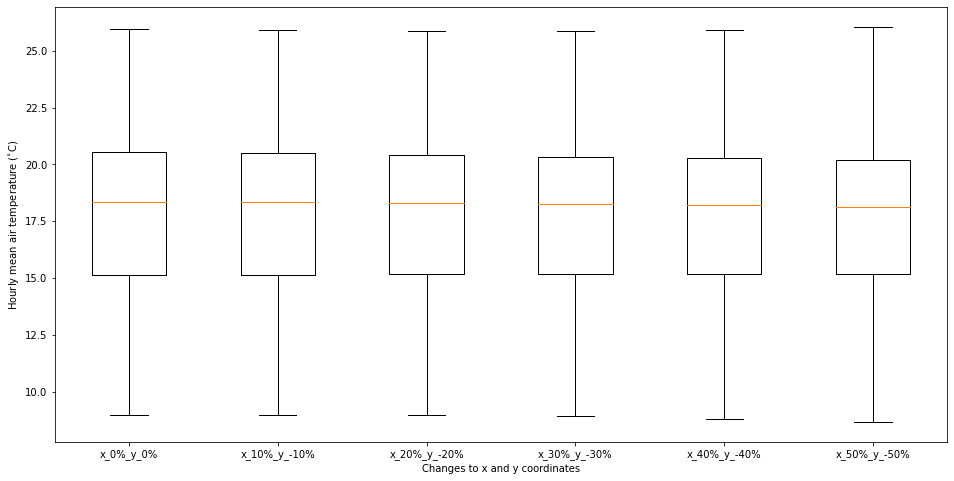

Figure 1: Box plot of hourly Zone One mean air temperatures for building footprint shapes.


In [13]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(16,8))
df_plot=df.pivot(index='Date/Time',
                 columns='simulation_run',
                 values='ZONE ONE:Zone Mean Air Temperature [C](Hourly)')
ax.boxplot(df_plot)
ax.set_xticklabels([x.partition('_')[2] for x in df_plot.columns])
ax.set_xlabel('Changes to x and y coordinates')
ax.set_ylabel('Hourly mean air temperature ($^{\circ}$C)')
fig.savefig('Boxplot.png')
plt.show()
print('Figure 1: Box plot of hourly Zone One mean air temperatures for building footprint shapes.')